## 6-1、构建模型的3种方法
可以使用以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

对于顺序结构的模型，优先使用Sequential方法构建。

如果模型有多输入或者多输出，或者模型需要共享权重，或者模型具有残差连接等非顺序结构，推荐使用函数式API进行创建。

如果无特定必要，尽可能避免使用Model子类化的方式构建模型，这种方式提供了极大的灵活性，但也有更大的概率出错。

下面以IMDB电影评论的分类问题为例，演示3种创建模型的方法。

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import *


train_token_path = "./data/imdb/train_token.csv"
test_token_path = "./data/imdb/test_token.csv"

MAX_WORDS = 10000  # We will only consider the top 10,000 words in the dataset
MAX_LEN = 200  # We will cut reviews after 200 words
BATCH_SIZE = 20 

# 构建管道
def parse_line(line):
    t = tf.strings.split(line,"\t")
    label = tf.reshape(tf.cast(tf.strings.to_number(t[0]),tf.int32),(-1,))
    features = tf.cast(tf.strings.to_number(tf.strings.split(t[1]," ")),tf.int32)
    return (features,label)

ds_train=  tf.data.TextLineDataset(filenames = [train_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

ds_test=  tf.data.TextLineDataset(filenames = [test_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

### 一、Sequential按层创建顺序模型

In [4]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN))
model.add(layers.Conv1D(filters=64,kernel_size=5,activation='relu'))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = "relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation = "sigmoid"))

model.compile(optimizer = 'Adam',
             loss= 'binary_crossentropy',
             metrics = ['accuracy','AUC'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 7)            70000     
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [5]:
import datetime
baselogger = callbacks.BaseLogger(stateful_metrics=["AUC"])
logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,validation_data = ds_test,
        epochs = 6,callbacks=[baselogger,tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.5178 - accuracy: 0.6942 - AUC: 0.8006 - val_loss: 0.3181 - val_accuracy: 0.8622 - val_AUC: 0.9384
Epoch 2/6
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2387 - accuracy: 0.9035 - AUC: 0.9655 - val_loss: 0.3464 - val_accuracy: 0.8582 - val_AUC: 0.9423
Epoch 3/6
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1513 - accuracy: 0.9427 - AUC: 0.9859 - val_loss: 0.4391 - val_accuracy: 0.8534 - val_AUC: 0.9334
Epoch 4/6
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0877 - accuracy: 0.9680 - AUC: 0.9949 - val_loss: 0.5500 - val_accuracy: 0.8592 - val_AUC: 0.9227
Epoch 5/6
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0441 - accuracy: 0.9851 - AUC: 0.9987 - val_loss: 0.7731 - val_accuracy: 0.8550 - val_AUC: 0.9110
Epoch 6/6
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0222 - accuracy: 0.9926 - AUC: 0.9996 - val_lo

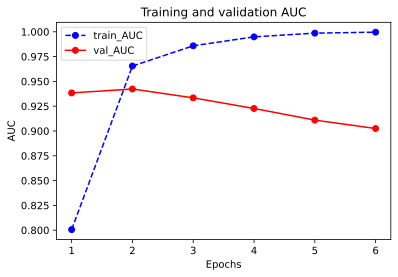

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history,"AUC")

### 二、函数式API创建任意结构模型

In [7]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape = [MAX_LEN])
x =  layers.Embedding(MAX_WORDS,7)(inputs)

branch1 =layers.SeparableConv1D(64,3,activation='relu')(x)
branch1 = layers.MaxPool1D(3)(branch1)
branch1 = layers.SeparableConv1D(32,3,activation="relu")(branch1)
branch1 = layers.GlobalMaxPool1D()(branch1)

branch2 = layers.SeparableConv1D(64,5,activation="relu")(x)
branch2 = layers.MaxPool1D(5)(branch2)
branch2 = layers.SeparableConv1D(32,5,activation="relu")(branch2)
branch2 = layers.GlobalMaxPool1D()(branch2)

branch3 = layers.SeparableConv1D(64,7,activation="relu")(x)
branch3 = layers.MaxPool1D(7)(branch3)
branch3 = layers.SeparableConv1D(32,7,activation="relu")(branch3)
branch3 = layers.GlobalMaxPool1D()(branch3)

concat = layers.Concatenate()([branch1,branch2,branch3])

outputs = layers.Dense(1,activation="sigmoid")(concat)

model = models.Model(inputs = inputs,outputs = outputs)
model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 7)       70000       input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 198, 64)      533         embedding[0][0]                  
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 196, 64)      547         embedding[0][0]                  
______________________________________________________________________________________________

In [11]:
history = model.fit(ds_train,validation_data=ds_test,epochs = 6,callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 13s 13ms/step - loss: 0.1640 - accuracy: 0.9376 - AUC: 0.9835 - val_loss: 0.3985 - val_accuracy: 0.8462 - val_AUC: 0.9269/step - loss: 0.1634 - accuracy: 0.9381 - AUC: 0.983 - 11s 12ms/step - loss: 0.1634 - accuracy: 0.9381 - AUC: 0 - 11s 12ms/step - loss: 0.1634 - accuracy: 0 - 12s 12ms/step - loss: 0.1
Epoch 2/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0936 - accuracy: 0.9706 - AUC: 0.9943 - val_loss: 0.4992 - val_accuracy: 0.8456 - val_AUC: 0.9188
Epoch 3/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0473 - accuracy: 0.9876 - AUC: 0.9981 - val_loss: 0.6325 - val_accuracy: 0.8406 - val_AUC: 0.9082
Epoch 4/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0206 - accuracy: 0.9962 - AUC: 0.9993 - val_loss: 0.7919 - val_accuracy: 0.8412 - val_AUC: 0.8999
Epoch 5/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0103 - accuracy: 0.9979 - AUC

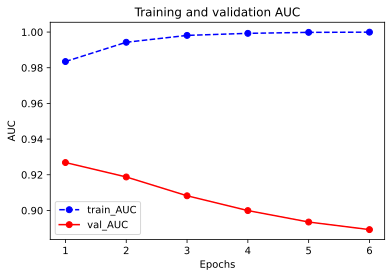

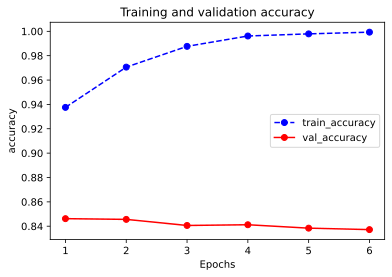

In [16]:
plot_metric(history,"AUC")
plot_metric(history,"accuracy")

## 三、Model子类化创建自定义模型

In [23]:
class ResBlock(layers.Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    
    def build(self,input_shape):
        self.conv1 = layers.Conv1D(filters=64,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv2 = layers.Conv1D(filters=32,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv3 = layers.Conv1D(filters=input_shape[-1],
                                   kernel_size=self.kernel_size,activation = "relu",padding="same")
        self.maxpool = layers.MaxPool1D(2)
        super(ResBlock,self).build(input_shape) # 相当于设置self.built = True
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = layers.Add()([inputs,x])
        x = self.maxpool(x)
        return x
    
    #如果要让自定义的Layer通过Functional API 组合成模型时可以序列化，需要自定义get_config方法。
    def get_config(self):  
        config = super(ResBlock, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config

In [24]:
# 测试ResBlock
resblock = ResBlock(kernel_size = 3)
resblock.build(input_shape = (None,200,7))
resblock.compute_output_shape(input_shape=(None,200,7))

TensorShape([None, 100, 7])

In [25]:
class ImdbModel(models.Model):
    def __init__(self):
        super(ImdbModel,self).__init()
    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7)
        self.block1 = ResBlock(7)
        self.block2 = ResBlock(3)
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(ImdbModel,self).build(input_shape)
    def call(self,x):
        x = self.embedding(x)
        x = self.block1(x)
        x = self.block2(x)
        x = layers.Flatten()(x)
        x = self.dense(x)
        return x

In [ ]:
tf.keras.backend.clear_session()

model = ImdbModel()
model.build(input_shape =(None,200))
model.summary()

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.fit(ds_train,validation_data = ds_test,)